<a href="https://www.kaggle.com/code/nilotpalmaitra/cleaned-vs-dirty-2?scriptVersionId=185706648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plates-dataset/plates/test/0664.jpg
/kaggle/input/plates-dataset/plates/test/0733.jpg
/kaggle/input/plates-dataset/plates/test/0106.jpg
/kaggle/input/plates-dataset/plates/test/0375.jpg
/kaggle/input/plates-dataset/plates/test/0285.jpg
/kaggle/input/plates-dataset/plates/test/0591.jpg
/kaggle/input/plates-dataset/plates/test/0074.jpg
/kaggle/input/plates-dataset/plates/test/0077.jpg
/kaggle/input/plates-dataset/plates/test/0498.jpg
/kaggle/input/plates-dataset/plates/test/0610.jpg
/kaggle/input/plates-dataset/plates/test/0617.jpg
/kaggle/input/plates-dataset/plates/test/0426.jpg
/kaggle/input/plates-dataset/plates/test/0235.jpg
/kaggle/input/plates-dataset/plates/test/0273.jpg
/kaggle/input/plates-dataset/plates/test/0307.jpg
/kaggle/input/plates-dataset/plates/test/0444.jpg
/kaggle/input/plates-dataset/plates/test/0058.jpg
/kaggle/input/plates-dataset/plates/test/0255.jpg
/kaggle/input/plates-dataset/plates/test/0128.jpg
/kaggle/input/plates-dataset/plates/test/0700.jpg


In [30]:
!pip install kaggle


In [31]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile 
from PIL import Image 
import cv2 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D,  BatchNormalization, Input, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, Recall

In [32]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [33]:
plates_file_zip ='/kaggle/input/platesv2/plates.zip'
plates_img_file = '/kaggle/working/'
os.makedirs(plates_img_file, exist_ok=True)
with zipfile.ZipFile(plates_file_zip, mode='r') as zip_folder:
    zip_folder.extractall(plates_img_file)

In [34]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [35]:
import shutil 
from tqdm import tqdm


train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5990.64it/s]


In [36]:
!ls train

cleaned  dirty


**Data Transformations (Data processing and augmentation)
**

In [37]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = [
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.3, hue=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
    transforms.Compose([
    transforms.RandomRotation(45),
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomGrayscale(p=1),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
]
val_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir,train_transform)
                                                    for train_transform in train_transforms])

val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir,train_transform)
                                                    for train_transform in train_transforms])

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
len(train_dataloader), len(train_dataset)

(28, 224)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


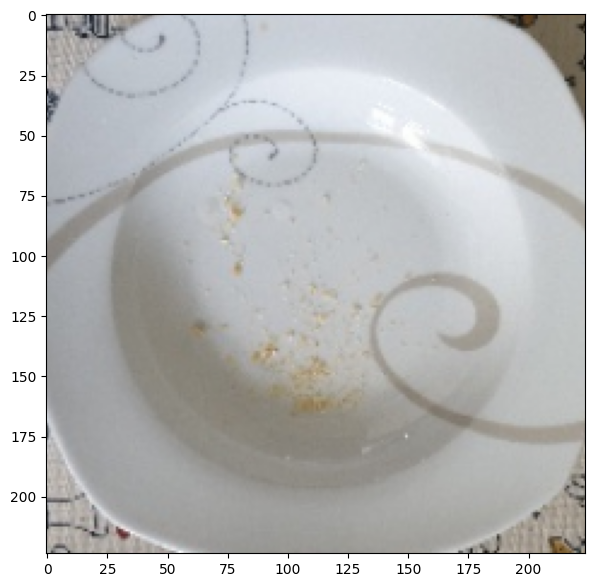

In [39]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

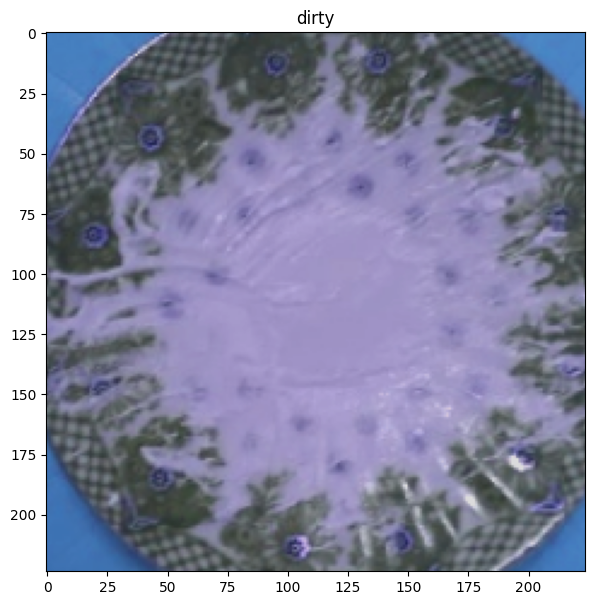

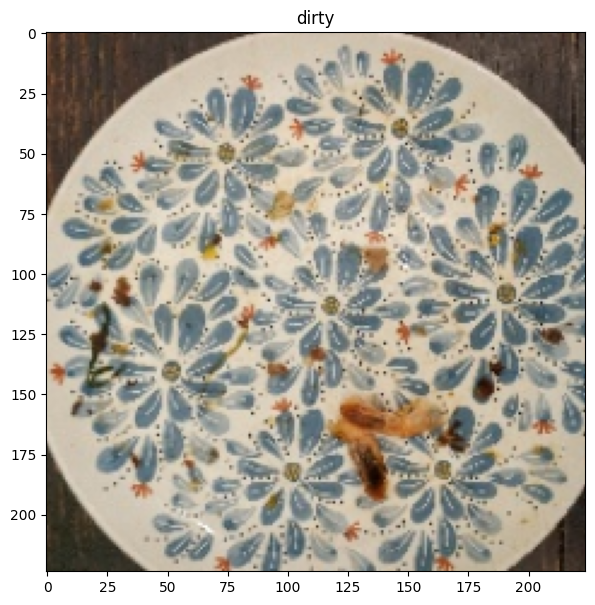

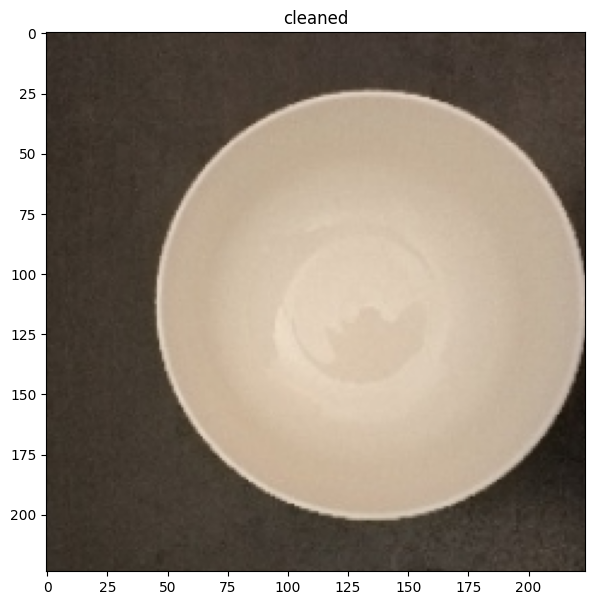

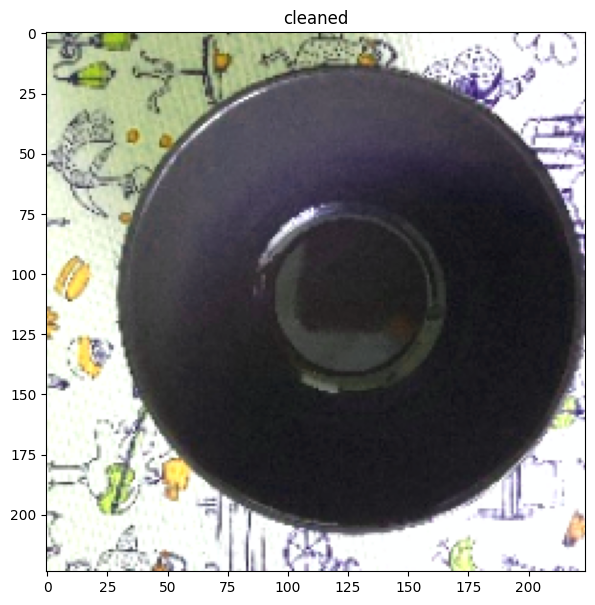

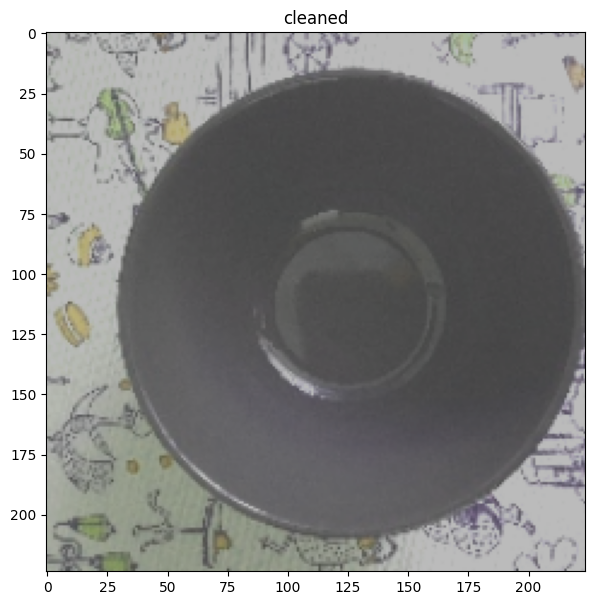

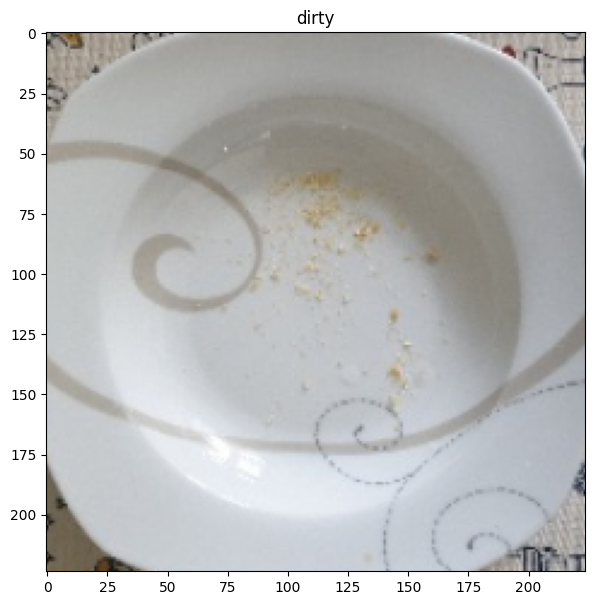

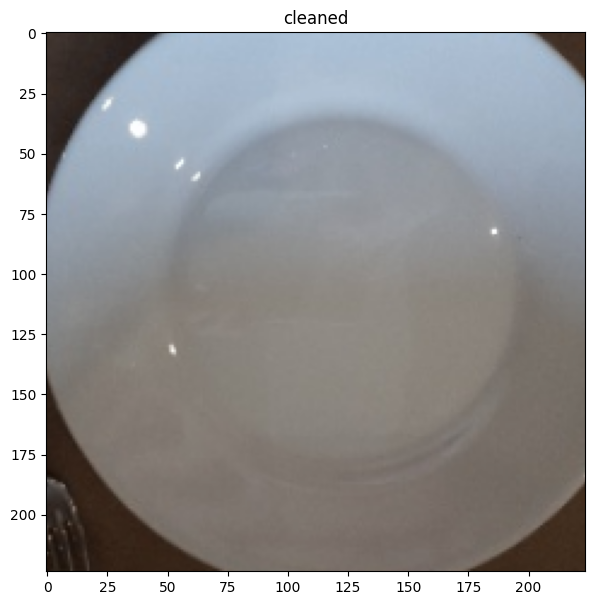

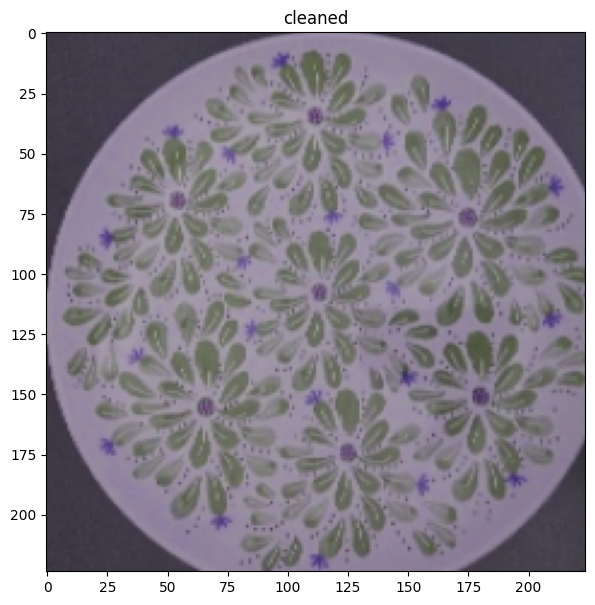

In [40]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [41]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    loss_hist = {'train':[], 'val':[]}
    accuracy_hist = {'train':[], 'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)

    return model, loss_hist, accuracy_hist

In [42]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False
    
for param in model.layer4.parameters():
            param.requires_grad = True

model.fc = torch.nn.Sequential(torch.nn.Dropout(0.4),torch.nn.Linear(model.fc.in_features, 64),torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(num_features=64),torch.nn.Dropout(0.3), torch.nn.Linear(64,2))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=50);

Epoch 0/49:


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 28/28 [00:01<00:00, 22.93it/s]

train Loss: 0.6494 Acc: 0.5893



100%|██████████| 7/7 [00:00<00:00, 15.24it/s]

val Loss: 0.5803 Acc: 0.8214
Epoch 1/49:



100%|██████████| 28/28 [00:01<00:00, 24.99it/s]

train Loss: 0.3516 Acc: 0.8795



100%|██████████| 7/7 [00:00<00:00, 14.64it/s]

val Loss: 0.5518 Acc: 0.8393
Epoch 2/49:



100%|██████████| 28/28 [00:01<00:00, 24.64it/s]

train Loss: 0.2660 Acc: 0.9063



100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

val Loss: 0.5081 Acc: 0.8214
Epoch 3/49:



100%|██████████| 28/28 [00:01<00:00, 25.46it/s]

train Loss: 0.2170 Acc: 0.9286



100%|██████████| 7/7 [00:00<00:00, 14.67it/s]

val Loss: 0.5654 Acc: 0.7857
Epoch 4/49:



100%|██████████| 28/28 [00:01<00:00, 24.98it/s]

train Loss: 0.1663 Acc: 0.9464



100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

val Loss: 0.5425 Acc: 0.8571
Epoch 5/49:



100%|██████████| 28/28 [00:01<00:00, 17.74it/s]

train Loss: 0.1703 Acc: 0.9464



100%|██████████| 7/7 [00:00<00:00, 14.15it/s]

val Loss: 0.5409 Acc: 0.8393
Epoch 6/49:



100%|██████████| 28/28 [00:01<00:00, 24.91it/s]

train Loss: 0.1483 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

val Loss: 0.5620 Acc: 0.8750
Epoch 7/49:



100%|██████████| 28/28 [00:01<00:00, 25.09it/s]

train Loss: 0.1392 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 14.66it/s]

val Loss: 0.5486 Acc: 0.8571
Epoch 8/49:



100%|██████████| 28/28 [00:01<00:00, 24.08it/s]

train Loss: 0.2052 Acc: 0.9420



100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

val Loss: 0.5775 Acc: 0.7321
Epoch 9/49:



100%|██████████| 28/28 [00:01<00:00, 24.82it/s]

train Loss: 0.1523 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 15.06it/s]

val Loss: 0.5310 Acc: 0.8750
Epoch 10/49:



100%|██████████| 28/28 [00:01<00:00, 25.06it/s]

train Loss: 0.1402 Acc: 0.9554



100%|██████████| 7/7 [00:00<00:00, 14.24it/s]

val Loss: 0.5574 Acc: 0.8571
Epoch 11/49:



100%|██████████| 28/28 [00:01<00:00, 24.44it/s]

train Loss: 0.1038 Acc: 0.9955



100%|██████████| 7/7 [00:00<00:00, 11.34it/s]

val Loss: 0.5312 Acc: 0.8571
Epoch 12/49:



100%|██████████| 28/28 [00:01<00:00, 21.47it/s]

train Loss: 0.1100 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.79it/s]

val Loss: 0.5507 Acc: 0.8571
Epoch 13/49:



100%|██████████| 28/28 [00:01<00:00, 24.83it/s]

train Loss: 0.1099 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.73it/s]

val Loss: 0.5272 Acc: 0.8571
Epoch 14/49:



100%|██████████| 28/28 [00:01<00:00, 23.74it/s]

train Loss: 0.1329 Acc: 0.9554



100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

val Loss: 0.5292 Acc: 0.8571
Epoch 15/49:



100%|██████████| 28/28 [00:01<00:00, 24.72it/s]

train Loss: 0.1044 Acc: 0.9866



100%|██████████| 7/7 [00:00<00:00, 15.18it/s]

val Loss: 0.5750 Acc: 0.8571
Epoch 16/49:



100%|██████████| 28/28 [00:01<00:00, 24.87it/s]

train Loss: 0.1363 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 15.11it/s]

val Loss: 0.5501 Acc: 0.7857
Epoch 17/49:



100%|██████████| 28/28 [00:01<00:00, 24.72it/s]

train Loss: 0.1443 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 14.94it/s]

val Loss: 0.5470 Acc: 0.8393
Epoch 18/49:



100%|██████████| 28/28 [00:01<00:00, 25.14it/s]

train Loss: 0.1392 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 14.12it/s]

val Loss: 0.5719 Acc: 0.8036
Epoch 19/49:



100%|██████████| 28/28 [00:01<00:00, 25.08it/s]

train Loss: 0.1561 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 15.23it/s]

val Loss: 0.5616 Acc: 0.8393
Epoch 20/49:



100%|██████████| 28/28 [00:01<00:00, 24.16it/s]

train Loss: 0.1101 Acc: 0.9821



100%|██████████| 7/7 [00:00<00:00, 14.46it/s]

val Loss: 0.5772 Acc: 0.8393
Epoch 21/49:



100%|██████████| 28/28 [00:01<00:00, 25.12it/s]

train Loss: 0.1454 Acc: 0.9598



100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

val Loss: 0.5528 Acc: 0.8036
Epoch 22/49:



100%|██████████| 28/28 [00:01<00:00, 24.86it/s]

train Loss: 0.1146 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 14.90it/s]

val Loss: 0.5456 Acc: 0.8750
Epoch 23/49:



100%|██████████| 28/28 [00:01<00:00, 24.75it/s]

train Loss: 0.1437 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

val Loss: 0.5560 Acc: 0.7321
Epoch 24/49:



100%|██████████| 28/28 [00:01<00:00, 25.04it/s]

train Loss: 0.1622 Acc: 0.9509



100%|██████████| 7/7 [00:00<00:00, 14.60it/s]

val Loss: 0.5525 Acc: 0.8571
Epoch 25/49:



100%|██████████| 28/28 [00:01<00:00, 24.52it/s]

train Loss: 0.1489 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 14.96it/s]

val Loss: 0.5962 Acc: 0.7857
Epoch 26/49:



100%|██████████| 28/28 [00:01<00:00, 24.63it/s]

train Loss: 0.1404 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 14.15it/s]

val Loss: 0.5412 Acc: 0.8571
Epoch 27/49:



100%|██████████| 28/28 [00:01<00:00, 24.60it/s]

train Loss: 0.1166 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

val Loss: 0.5346 Acc: 0.8393
Epoch 28/49:



100%|██████████| 28/28 [00:01<00:00, 25.12it/s]

train Loss: 0.0883 Acc: 0.9955



100%|██████████| 7/7 [00:00<00:00, 14.39it/s]

val Loss: 0.5458 Acc: 0.8750
Epoch 29/49:



100%|██████████| 28/28 [00:01<00:00, 24.59it/s]

train Loss: 0.1597 Acc: 0.9375



100%|██████████| 7/7 [00:00<00:00, 13.85it/s]

val Loss: 0.5683 Acc: 0.8393
Epoch 30/49:



100%|██████████| 28/28 [00:01<00:00, 24.14it/s]

train Loss: 0.1375 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 14.94it/s]

val Loss: 0.5578 Acc: 0.8571
Epoch 31/49:



100%|██████████| 28/28 [00:01<00:00, 20.64it/s]

train Loss: 0.1369 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 12.68it/s]

val Loss: 0.5485 Acc: 0.8571
Epoch 32/49:



100%|██████████| 28/28 [00:01<00:00, 24.82it/s]

train Loss: 0.1295 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 14.93it/s]

val Loss: 0.5540 Acc: 0.8393
Epoch 33/49:



100%|██████████| 28/28 [00:01<00:00, 24.74it/s]

train Loss: 0.1247 Acc: 0.9821



100%|██████████| 7/7 [00:00<00:00, 14.22it/s]

val Loss: 0.5440 Acc: 0.8393
Epoch 34/49:



100%|██████████| 28/28 [00:01<00:00, 25.00it/s]

train Loss: 0.1235 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

val Loss: 0.5425 Acc: 0.8571
Epoch 35/49:



100%|██████████| 28/28 [00:01<00:00, 24.90it/s]

train Loss: 0.1114 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 15.11it/s]

val Loss: 0.5402 Acc: 0.8750
Epoch 36/49:



100%|██████████| 28/28 [00:01<00:00, 25.02it/s]

train Loss: 0.1369 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

val Loss: 0.5813 Acc: 0.8036
Epoch 37/49:



100%|██████████| 28/28 [00:01<00:00, 24.23it/s]

train Loss: 0.1298 Acc: 0.9598



100%|██████████| 7/7 [00:00<00:00, 14.77it/s]

val Loss: 0.5718 Acc: 0.8214
Epoch 38/49:



100%|██████████| 28/28 [00:01<00:00, 24.39it/s]

train Loss: 0.1124 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

val Loss: 0.5454 Acc: 0.8571
Epoch 39/49:



100%|██████████| 28/28 [00:01<00:00, 25.18it/s]

train Loss: 0.1466 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 15.13it/s]

val Loss: 0.5527 Acc: 0.8571
Epoch 40/49:



100%|██████████| 28/28 [00:01<00:00, 25.01it/s]

train Loss: 0.1328 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.93it/s]

val Loss: 0.5409 Acc: 0.8571
Epoch 41/49:



100%|██████████| 28/28 [00:01<00:00, 24.81it/s]

train Loss: 0.1292 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.94it/s]

val Loss: 0.5513 Acc: 0.8571
Epoch 42/49:



100%|██████████| 28/28 [00:01<00:00, 24.80it/s]

train Loss: 0.1380 Acc: 0.9643



100%|██████████| 7/7 [00:00<00:00, 15.18it/s]

val Loss: 0.5645 Acc: 0.8393
Epoch 43/49:



100%|██████████| 28/28 [00:01<00:00, 25.28it/s]

train Loss: 0.1213 Acc: 0.9509



100%|██████████| 7/7 [00:00<00:00, 14.83it/s]

val Loss: 0.5912 Acc: 0.7857
Epoch 44/49:



100%|██████████| 28/28 [00:01<00:00, 25.02it/s]

train Loss: 0.1538 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 14.22it/s]

val Loss: 0.5570 Acc: 0.8571
Epoch 45/49:



100%|██████████| 28/28 [00:01<00:00, 24.83it/s]

train Loss: 0.1250 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 15.08it/s]

val Loss: 0.5693 Acc: 0.8393
Epoch 46/49:



100%|██████████| 28/28 [00:01<00:00, 25.13it/s]

train Loss: 0.1345 Acc: 0.9688



100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

val Loss: 0.5566 Acc: 0.7857
Epoch 47/49:



100%|██████████| 28/28 [00:01<00:00, 25.07it/s]

train Loss: 0.1222 Acc: 0.9821



100%|██████████| 7/7 [00:00<00:00, 13.99it/s]

val Loss: 0.5416 Acc: 0.8750
Epoch 48/49:



100%|██████████| 28/28 [00:01<00:00, 24.49it/s]

train Loss: 0.1284 Acc: 0.9732



100%|██████████| 7/7 [00:00<00:00, 14.37it/s]

val Loss: 0.5508 Acc: 0.8571
Epoch 49/49:



100%|██████████| 28/28 [00:01<00:00, 23.52it/s]

train Loss: 0.1118 Acc: 0.9777



100%|██████████| 7/7 [00:00<00:00, 14.61it/s]

val Loss: 0.5603 Acc: 0.8571


In [44]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [45]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [46]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(200, 200))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [47]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 28.00it/s]


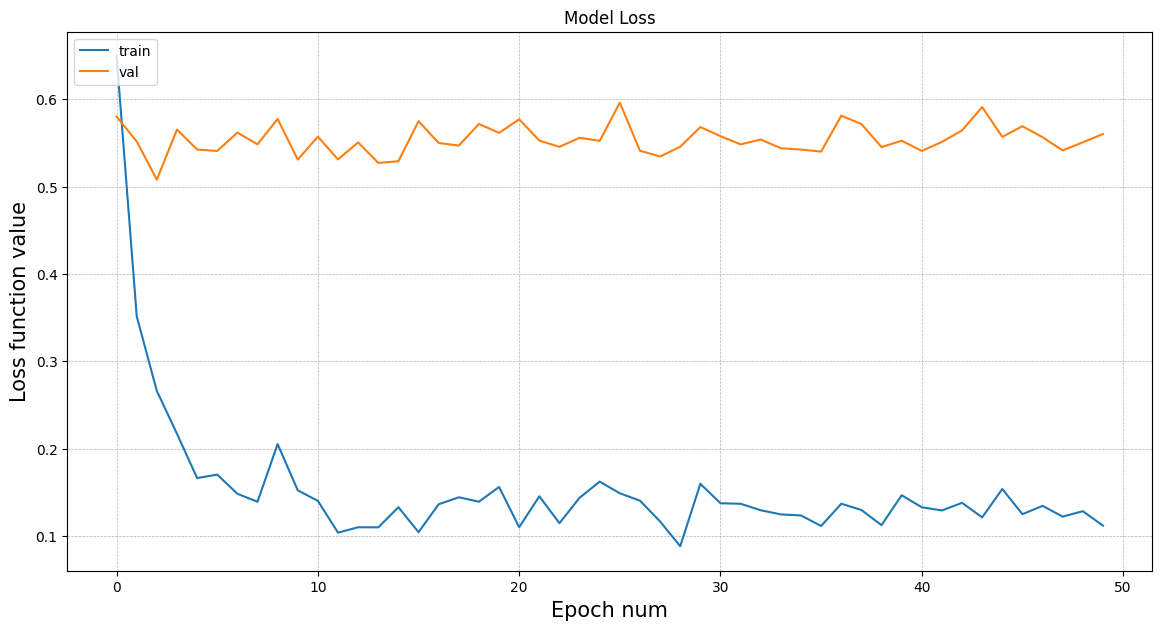

In [48]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

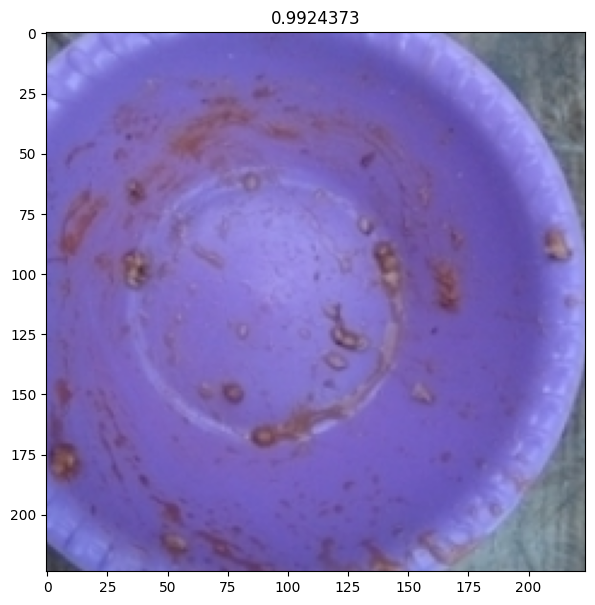

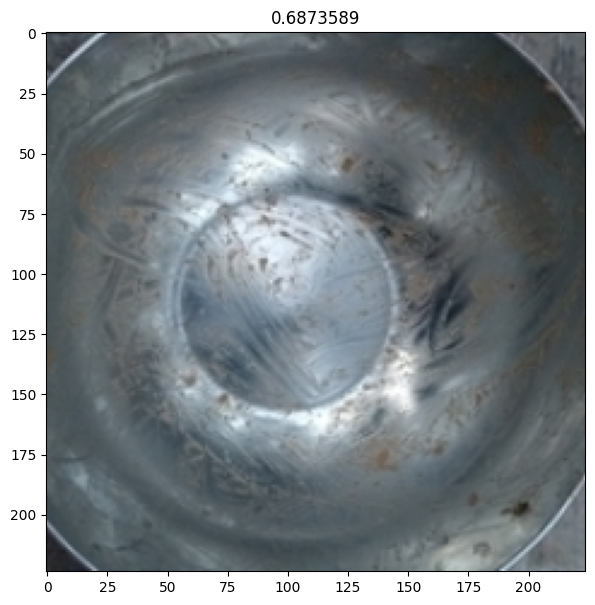

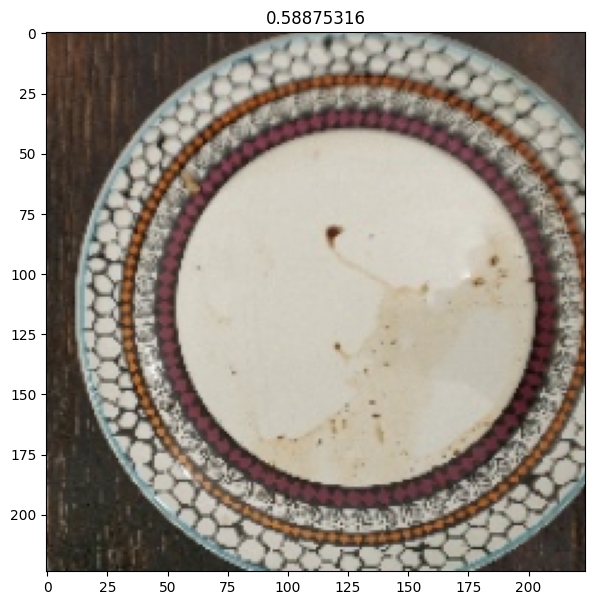

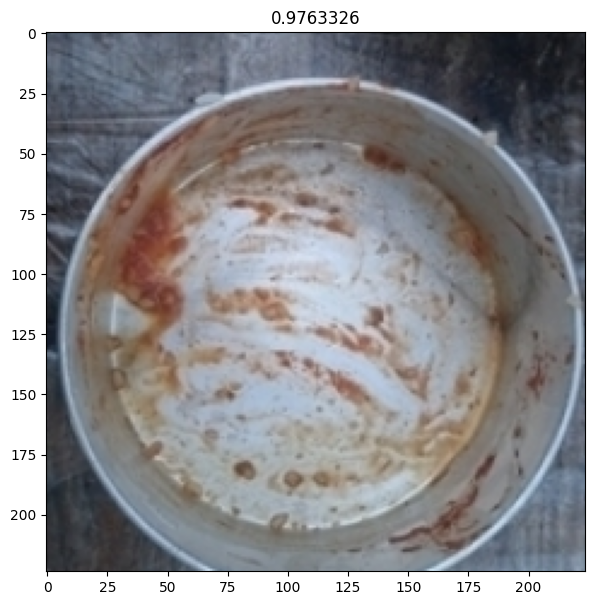

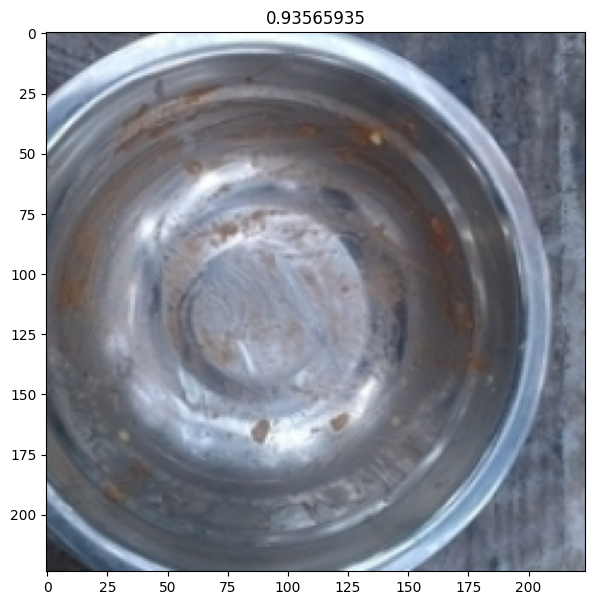

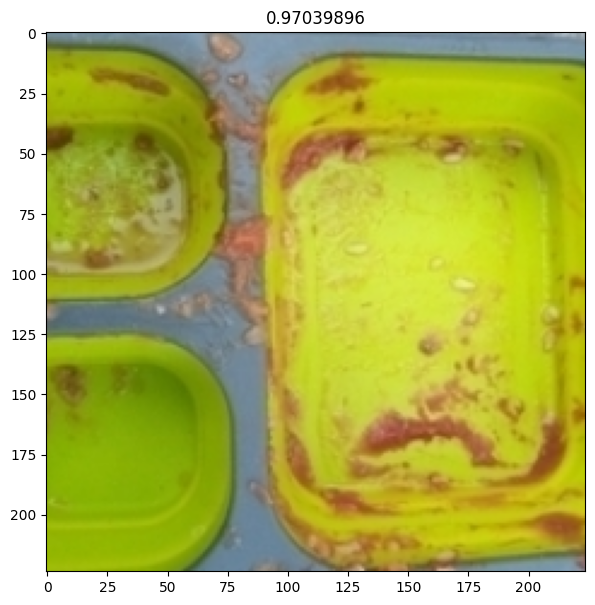

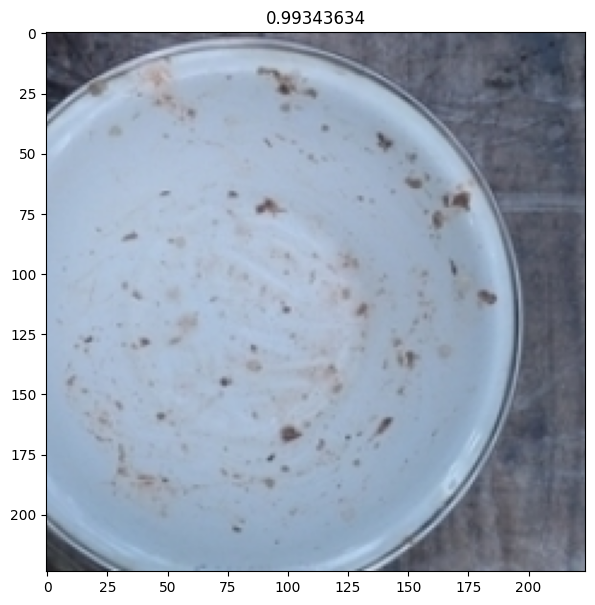

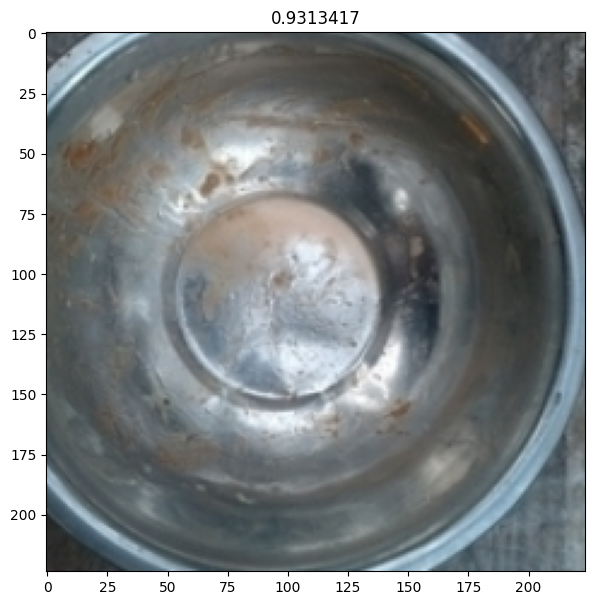

In [49]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [50]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [51]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.8 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001  cleaned
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

In [52]:
submission_df.to_csv('submission.csv')

In [53]:
!rm -rf train val test

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
